In [1]:
import argparse

from unityagents import UnityEnvironment

import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Model

A feedforward neural network with two hidden layers plus the final layer. The hidden layers are made of 64 units each. The final layer outputs a predicted Q-value for each of the possible 4 actions. The non-linear activation function selected is ReLU. No dropout layers were added to prevent overfitting.

In addition, a dueling architecture is implemented and activated by default.

In [2]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, fc1_units)

        self.fc2_adv = nn.Linear(fc1_units, fc2_units)
        self.fc2_val = nn.Linear(fc1_units, fc2_units)

        self.fc3_adv = nn.Linear(fc2_units, action_size)
        self.fc3_val = nn.Linear(fc2_units, 1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        y = F.relu(self.fc1(state))

        adv = F.relu(self.fc2_adv(y))
        val = F.relu(self.fc2_val(y))

        adv = self.fc3_adv(adv)
        val = self.fc3_val(val)

        x = val + adv - torch.mean(adv, dim=1, keepdim=True)

        return x

## Agent

List of hyperparameters:

In [3]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
ALPHA = 0.6             # degree of randomness for sampling probabilty (0 = pure uniform randomess; 1 = only use priorities)
BETA = 0.4              # initial value for beta, which controls how much importance weights affect learning
BETA_ITERS = 25000      # number of iterations over which beta will be annealed from initial value to 1
EPSILON_PER = 0.2       # prioritized experience replay epsilon. A very small number just to prevent zero divion for probabilities

Both Double Q-learning and Prioritized Experience Replay are implemented and activated by default.

In [4]:
# Use the GPU by default, if available:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed, ALPHA)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

        # Initialize learning step for updating beta
        self.learn_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get prioritized subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA, BETA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma, beta):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
            beta (float): initial value for beta, which controls how much importance weights affect learning
        """
        states, actions, rewards, next_states, dones, probabilities, indices = experiences

        ### Double Q-learning:
        # Get the Q values for each next_state, action pair from the 
        # local/online/behavior Q network:
        Q_targets_next_local = self.qnetwork_local(next_states).detach()
        # Get the corresponding best action for those next_states:
        _, a_prime = Q_targets_next_local.max(1)

        # Get the Q values from the target Q network but following a_prime,
        # which belongs to the local network, not the target network:
        Q_targets_next = self.qnetwork_target(next_states).detach()
        Q_targets_next = Q_targets_next.gather(1, a_prime.unsqueeze(1))
        ###

        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)   

        # Compute and update new priorities
        new_priorities = (abs(Q_expected - Q_targets) + EPSILON_PER).detach()
        self.memory.update_priority(new_priorities, indices)

        # Update beta parameter (b). By default beta will reach 1 after 
        # 25,000 training steps (~325 episodes in the Banana environment):
        b = min(1.0, beta + self.learn_step * (1.0 - beta) / BETA_ITERS)
        self.learn_step += 1

        # Compute and apply importance sampling weights to TD Errors
        ISweights = (((1 / len(self.memory)) * (1 / probabilities)) ** b)
        max_ISweight = torch.max(ISweights)
        ISweights /= max_ISweight
        Q_targets *= ISweights
        Q_expected *= ISweights

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Replay buffer

[Prioritized Experience Replay](https://arxiv.org/pdf/1511.05952) implementation  is not mine. It was borrowed from [austinsilveria](https://github.com/austinsilveria/Banana-Collection-DQN), which is based on an unsorted [sum tree model](https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/) to sample the tuples from the replay buffer more efficiently based on the TD error criteria. Consequently, a separate class to handle sum tree model is created.

In [5]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, alpha):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = SumTree(buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done", "priority"])
        # Set alpha parameter to control the degree of uniform random 
        # sampling:
        self.alpha = alpha
        self.max_priority = 0
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done, priority=10):
        """Add a new experience to memory including its priority to be later sampled from the experience pool"""

        # If the experience pool is smaller than the batch size, then assign
        # the maximum priority bu default:
        if len(self.memory) > self.batch_size + 5:
            e = self.experience(state, action, reward, next_state, done, self.max_priority)
        # Otherwise assign priority to the power of alpha:
        else:
            e = self.experience(state, action, reward, next_state, done, int(priority) ** self.alpha)
        self.memory.add(e)

    def update_priority(self, new_priorities, indices):
        """Updates priority of experience after learning."""
        for new_priority, index in zip(new_priorities, indices):
            old_e = self.memory[index]
            new_p = new_priority.item() ** self.alpha
            new_e = self.experience(old_e.state, old_e.action, old_e.reward, old_e.next_state, old_e.done, new_p)
            #self.memory.update(index, new_e)
            self.memory.update(index.item(), new_e)
            if new_p > self.max_priority:
                self.max_priority = new_p

    def sample(self):
        """
        Sample a batch of experiences from the memory pool based on TD Error
        priority. Return indices of sampled experiences in order to update 
        their priorities after learning from them.
        """
        experiences = []
        indices = []
        sub_array_size = self.memory.get_sum() / self.batch_size
        for i in range(self.batch_size):
            choice = np.random.uniform(sub_array_size * i, sub_array_size * (i + 1))
            e, index = self.memory.retrieve(1, choice)
            experiences.append(e)
            indices.append(index)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        probabilities = torch.from_numpy(np.vstack([e.priority / self.memory.get_sum() for e in experiences])).float().to(device)
        indices = torch.from_numpy(np.vstack([i for i in indices])).int().to(device)

        return states, actions, rewards, next_states, dones, probabilities, indices

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

class SumTree:
    """
    Leaf nodes hold experiences and intermediate nodes store experience priority sums.
    Adapted from: https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/
    """

    def __init__(self, maxlen):
        """Initialize a SumTree object.

        Params
        ======
            maxlen (int): maximum size of replay buffer
        """
        self.sumList = np.zeros(maxlen*2)
        self.experiences = np.zeros(maxlen*2, dtype=object)
        self.maxlen = maxlen
        self.currentSize = 0
        # Set insertion marker for next item as first leaf
        self.tail = ((len(self.sumList)-1) // 2) + 1

    def add(self, experience):
        """Add experience to array and experience priority to sumList."""
        if self.tail == len(self.sumList):
            self.tail = ((len(self.sumList)-1) // 2) + 1
        self.experiences[self.tail] = experience
        old = self.sumList[self.tail]
        self.sumList[self.tail] = experience.priority
        if old == 0:
            change = experience.priority
            self.currentSize += 1
        else:
            change = experience.priority - old
        self.propagate(self.tail, change)
        self.tail += 1

    def propagate(self, index, change):
        """Updates sum tree to reflect change in priority of leaf."""
        parent = index // 2
        if parent == 0:
            return
        self.sumList[parent] += change
        self.propagate(parent, change)

    def get_sum(self):
        """Return total sum of priorities."""
        return self.sumList[1]

    def retrieve(self, start_index, num):
        """Return experience at index in which walking the array and summing the probabilities equals num."""
        # Return experience if we reach leaf node
        if self.left(start_index) > len(self.sumList) - 1:
            return self.experiences[start_index], start_index
        # If left sum is greater than num, we look in left subtree
        if self.sumList[self.left(start_index)] >= num:
            return self.retrieve(self.left(start_index), num)
        # If left sum is not greater than num, we subtract the left sum and look in right subtree
        return self.retrieve(self.right(start_index), num - self.sumList[self.left(start_index)])

    def update(self, index, experience):
        """Updates experience with new priority."""
        self.experiences[index] = experience
        old_e_priority = self.sumList[index]
        self.sumList[index] = experience.priority
        change = experience.priority - old_e_priority
        self.propagate(index, change)

    def left(self, index):
        return index * 2

    def right(self, index):
        return index * 2 + 1

    def __getitem__(self, index):
        return self.experiences[index]

    def __len__(self):
        return self.currentSize

## Learning function

In [6]:
def dqn(env, brain_name, agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    print_solved_flag=False            # warn when the the average reward reaches 13.0
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        #state = env.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            #next_state, reward, done, _ = env.step(action)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0 and print_solved_flag==False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            print_solved_flag=True
            #torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            #break
    
    print('\nTraining finished! Saving weights...')
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    
    return scores

## Training

It is assumed that the environment file is in the same path that this notebook. By default, the Mac environment. If that is not the case, please change the first line according to the right path and the file that matches your OS.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.05
Episode 200	Average Score: 2.64
Episode 300	Average Score: 6.39
Episode 400	Average Score: 8.26
Episode 500	Average Score: 12.10
Episode 541	Average Score: 13.07
Environment solved in 541 episodes!	Average Score: 13.07
Episode 600	Average Score: 14.39
Episode 700	Average Score: 15.89
Episode 800	Average Score: 16.48
Episode 900	Average Score: 15.94
Episode 1000	Average Score: 16.50
Episode 1100	Average Score: 16.53
Episode 1200	Average Score: 16.36
Episode 1300	Average Score: 16.94
Episode 1400	Average Score: 16.45
Episode 1500	Average Score: 17.26
Episode 1600	Average Score: 16.19
Episode 1700	Average Score: 16.77
Episode 1800	Average Score: 16.53
Episode 1900	Average Score: 16.55
Episode 2000	Average Score: 15.77

Training finished! Saving weights...
To finish the program, manually close the plot window.


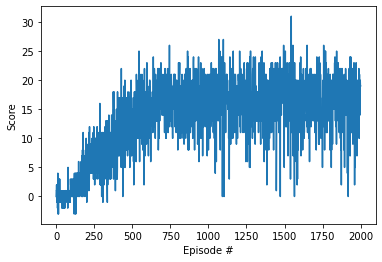

Done!


In [7]:
env = UnityEnvironment(file_name="./Banana.app", worker_id=1)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# instantiate agent
env_info = env.reset(train_mode=False)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

# start training
scores = dqn(env, brain_name, agent)

# close environment
#env.close()

# Write scores in file for later plot edition:
#np.save("scores", scores)  

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
print("Done!")

## Running the agent

Now it's time to watch the agent act according to he learnt.

If you get the following error trying to run the next cell `OSError: handle is closed`, shutdown and reinitiate this notebook and run only this last cell again. For more info about this bug go to https://github.com/Unity-Technologies/ml-agents/issues/1167

In [7]:
env = UnityEnvironment(file_name="./Banana.app", worker_id=2)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Instantiate agent:
env_info = env.reset(train_mode=False)[brain_name]
#agent = Agent(state_size=8, action_size=4, seed=0)
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    #state = env.reset()
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    for j in range(200):
        action = agent.act(state)
        #state, reward, done, _ = env.step(action)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        if done:
            break
        state = next_state

env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
